### Remove scroll from figures

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Extend the size of the Window

In [18]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load Modules

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [20]:
import netCDF4 as nc
import glob
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import cftime
import cartopy.crs as ccrs
from datetime import datetime

import colorcet as cc

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

from tqdm.notebook import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

import numpyro
numpyro.enable_x64()
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.contrib.nested_sampling import NestedSampler

import dill


## Read CMIP Data into xarray

In [21]:
# Define paths
geoDataPath = '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/**/'
save_path = '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.nc'

In [22]:
# Find files
geoFiles = glob.glob(geoDataPath + '*.nc', recursive=True)
geoFiles


['/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1985.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1986.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1987.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1988.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1989.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1990.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1991.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1992.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1993.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1994.nc',
 '/d0/amunozj/git_repos/interconnection-sun-climate/air_temperature/air.2m.gauss.1995.nc',

### Create variables for geo run

In [23]:

# geo_data = None
# for file in geoFiles:
#     if geo_data is None:
#         geo_data = xr.open_dataset(file)
#     else:
#         geo_data = geo_data.combine_first(xr.open_dataset(file))

# geo_data.to_netcdf(save_path)


In [24]:
geo_data = xr.open_dataset(save_path)
# geo_data['air'] = geo_data['air'] -273.15
geo_data

<xarray.Dataset> Size: 1GB
Dimensions:    (time: 16710, nbnds: 2, level: 1, lat: 94, lon: 192)
Coordinates:
  * level      (level) float32 4B 2.0
  * lat        (lat) float32 376B 88.54 86.65 84.75 ... -84.75 -86.65 -88.54
  * lon        (lon) float32 768B 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time       (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-09-30
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 267kB ...
    air        (time, level, lat, lon) float32 1GB ...
Attributes:
    Conventions:    CF-1.0
    title:          Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

### Explore seasonal function family based on powers of sines

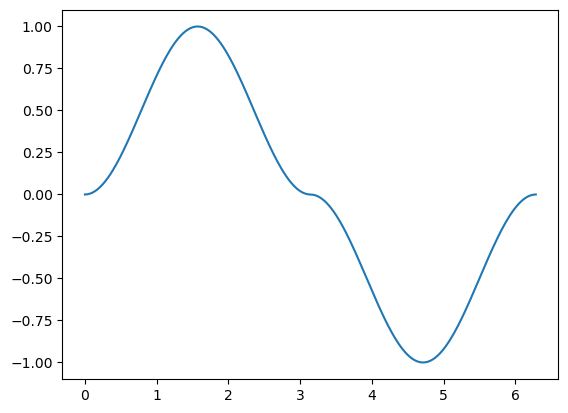

In [25]:
x = np.linspace(0,1,360)*2*np.pi
plt.plot(x, np.sign(np.sin(x))*(np.abs(np.sin(x)))**2)

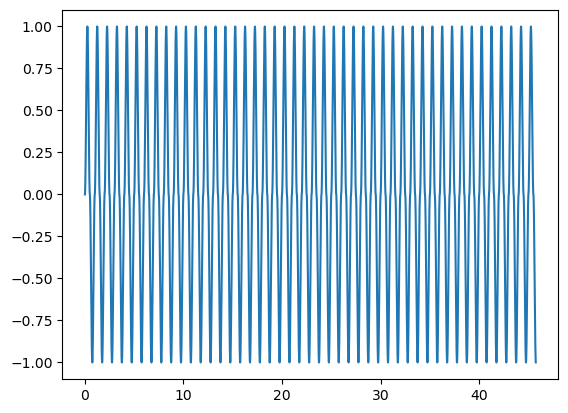

In [26]:
orbits = ((geo_data.time-np.min(geo_data.time))/np.timedelta64(1, 'D')/365.256).values

plt.plot(orbits, np.sign(np.sin(orbits*2*np.pi))*(np.abs(np.sin(orbits*2*np.pi)))**2)

In [27]:
geo_data.air.min().values-273.15

-93.7500061035156

In [28]:
geo_data.air.max().values-273.15

45.15999755859377

### Rebin data to coarser grids

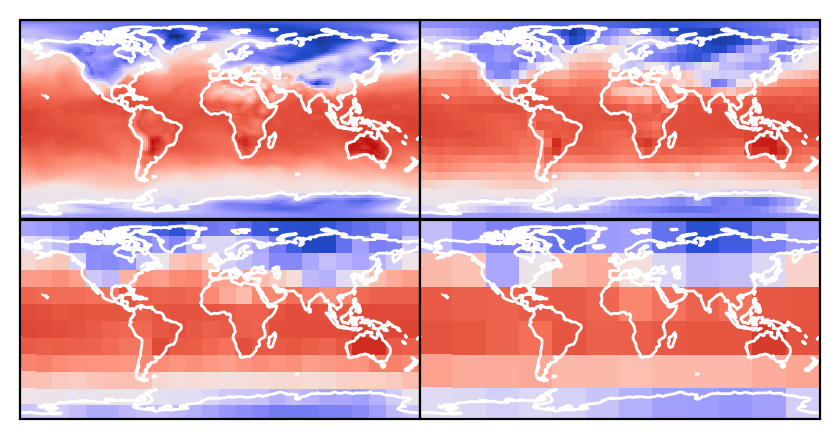

In [29]:
vmin = -50+273.15
vmax = 50+273.15
cmap = cc.cm.CET_D1A

fig = plt.figure(figsize=2*np.array([2, 1]), dpi=200)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0], projection=ccrs.PlateCarree())
geo_data.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False, cmap=cmap)
ax.coastlines(color='w')

geo_data_coarse8 = geo_data.coarsen(lon=4, lat=4, boundary='pad').mean()
ax = fig.add_subplot(gs0[0, 1], projection=ccrs.PlateCarree())
geo_data_coarse8.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False, cmap=cmap)
ax.coastlines(color='w')

geo_data_coarse15 = geo_data.coarsen(lon=8, lat=8, boundary='pad').mean()
ax = fig.add_subplot(gs0[1, 0], projection=ccrs.PlateCarree())
geo_data_coarse15.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False, cmap=cmap)
ax.coastlines(color='w')

geo_data_coarse30 = geo_data.coarsen(lon=16, lat=16, boundary='pad').mean()
ax = fig.add_subplot(gs0[1, 1], projection=ccrs.PlateCarree())
geo_data_coarse30.air.isel(time=0).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False, cmap=cmap)
ax.coastlines(color='w')

In [30]:
geo_data_coarse30

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 16710, nbnds: 2, level: 1, lat: 6, lon: 12)
Coordinates:
  * level      (level) float32 4B 2.0
  * lat        (lat) float32 24B 74.28 43.81 13.33 -17.14 -47.62 -76.18
  * lon        (lon) float32 48B 14.06 44.06 74.06 104.1 ... 284.1 314.1 344.1
  * time       (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-09-30
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 267kB 1979-01-01 ... 2024-10-01
    air        (time, level, lat, lon) float32 5MB 256.0 245.3 ... 252.0 250.5
Attributes:
    Conventions:    CF-1.0
    title:          Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

### Read CO2 concentration

<xarray.Dataset> Size: 247kB
Dimensions:  (time: 15464)
Coordinates:
  * time     (time) datetime64[ns] 124kB 1974-05-19 1974-05-20 ... 2024-10-24
Data variables:
    CO2      (time) float64 124kB 333.5 333.6 333.5 333.2 ... 422.0 422.1 422.1

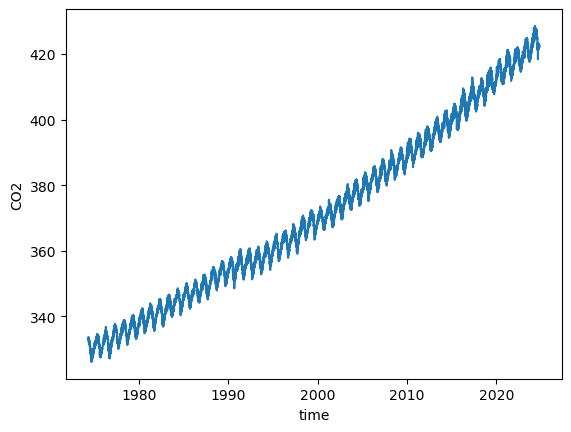

In [31]:
df = pd.read_csv('/d0/amunozj/git_repos/interconnection-sun-climate/co2_daily_mlo.csv', engine="c", header=32)
df['time'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.set_index('time', drop=True).loc[:,['CO2']]

co2_data = xr.Dataset.from_dataframe(df)
# co2_data = co2_data.interp(time=geo_data_coarse30.time.values)
co2_data.CO2.plot()
co2_data

### Read El Niño index

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4016646/57781222.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_table('/d0/amunozj/git_repos/interconnection-sun-climate/ENI/detrend.nino34.ascii.txt', engine="c", sep='\s+')


<xarray.Dataset> Size: 36kB
Dimensions:     (time: 897)
Coordinates:
  * time        (time) datetime64[ns] 7kB 1950-01-15 1950-02-15 ... 2024-09-15
Data variables:
    TOTAL       (time) float64 7kB 24.56 25.07 25.88 26.29 ... 27.34 26.74 26.44
    ClimAdjust  (time) float64 7kB 26.18 26.39 26.95 27.39 ... 27.29 26.86 26.72
    oni         (time) float64 7kB -1.62 -1.32 -1.07 -1.1 ... 0.05 -0.12 -0.28
    normalized  (time) float64 7kB -1.904 -1.555 -1.264 ... -0.1576 -0.3439

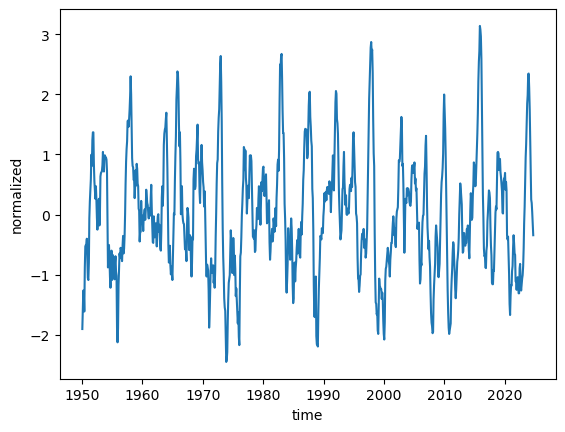

In [32]:
df = pd.read_table('/d0/amunozj/git_repos/interconnection-sun-climate/ENI/detrend.nino34.ascii.txt', engine="c", sep='\s+')
df['DAY'] = 15
df['time'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.set_index('time', drop=True).loc[:,['TOTAL', 'ClimAdjust']]

oni_data = xr.Dataset.from_dataframe(df)
# oni_data = oni_data.interp(time=geo_data_coarse30.time.values, kwargs={'fill_value':'extrapolate'})
# oni_data.ClimAdjust.plot()
# oni_data.TOTAL.plot()

oni_data['oni'] = oni_data.TOTAL - oni_data.ClimAdjust
oni_data['normalized'] = (oni_data.oni - oni_data.oni.mean())/oni_data.oni.std()


oni_data.normalized.plot()
oni_data

<xarray.Dataset> Size: 41kB
Dimensions:               (time: 725)
Coordinates:
  * time                  (time) datetime64[ns] 6kB 1964-05-01 ... 2024-09-01
Data variables:
    Timestamp             (time) object 6kB '1964-05-01T00:00:00Z' ... '2024-...
    FractionalDate        (time) float64 6kB 1.964e+03 1.964e+03 ... 2.025e+03
    UncorrectedCountRate  (time) int64 6kB 5945 6008 6059 ... 5637 5553 5176
    CorrectedCountRate    (time) int64 6kB 6424 6427 6461 ... 5983 5848 5715
    Pressure              (time) float64 6kB 1.011e+03 1.009e+03 ... 1.014e+03
    normalized            (time) float64 6kB 0.6251 0.6333 ... -0.9525 -1.317

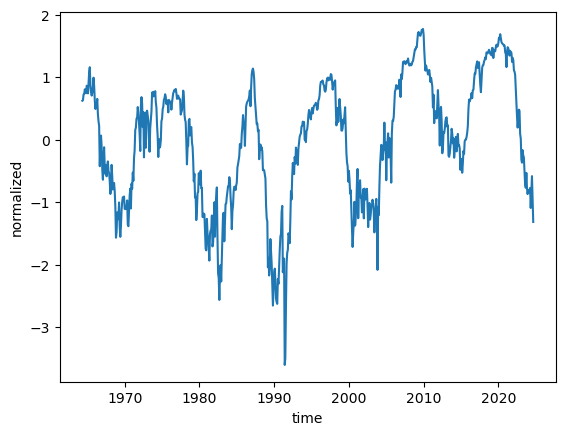

In [33]:
# Define path
crDataPath = '../../data/cosmic_rays/OULU_1964_05_01 _00_00_2024_10_28 _23_30.csv'

# Read cr monthly average file with custom column names\
cr = pd.read_csv(crDataPath)
cr['time'] = pd.to_datetime(cr['Timestamp']).dt.tz_localize(None).astype('datetime64[ns]')
cr = cr.set_index('time', drop=True)
cr = xr.Dataset.from_dataframe(cr)
# cr['crav'] = cr['CorrectedCountRate[cts/min]'].rolling(time=365, min_periods=1, center=True).mean()
# cr = cr.sel(time=slice(np.min(hist_sol.time.data)-pd.Timedelta(0, 'd'), np.max(hist_sol.time.data)))

# # Convert to seasonal average
# cr = cr['CorrectedCountRate[cts/min]'].resample(time='QS-DEC').mean().to_dataset(name = 'cr')

# # Reset index to middle of the season
# cr['time'] = cr['time'] + pd.to_timedelta(45, 'd')
# # Select only whole seasons
# cr = cr.sel(time=slice('1983-01-01', '2022-09-30'))
# cr['time'] = xr.CFTimeIndex.to_datetimeindex(cr['time'], unsafe=True)

cr['normalized'] = (cr.CorrectedCountRate - cr.CorrectedCountRate.mean())/cr.CorrectedCountRate.std()
cr.normalized.plot()

cr

## Read output of NC fits

In [302]:
abs_shift = False

DATA_LABEL = "air_temperature"
MCMC_OUT_FOLDER = (
    f"/d0/amunozj/git_repos/interconnection-sun-climate/outputs/nested_sampling"
    # f"/d0/amunozj/git_repos/interconnection-sun-climate/outputs/nested_sampling_negative_shift/air_temperature"
)
coarsen_level = 8
geo_data_coarse = geo_data.coarsen(lon=coarsen_level, lat=coarsen_level, boundary='pad').mean()

results_co2_season = []
results_co2_season_oni = []
results_co2_season_cr = []
results_co2_season_oni_cr = []

output_folder = os.path.join(MCMC_OUT_FOLDER, f"level_{coarsen_level}")
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

pbar2 = tqdm(
    range(geo_data_coarse.lon.shape[0]),
    position=0,
    total=geo_data_coarse.lon.shape[0],
    leave=False,
)
for lon_index in pbar2:
    pbar2.set_postfix_str(
        f"Processing {geo_data_coarse.lon.values[lon_index]}° longitude",
        refresh=True,
    )

    pbar3 = tqdm(
        range(geo_data_coarse.lat.shape[0]),
        position=1,
        total=geo_data_coarse.lat.shape[0],
        leave=False,
    )
    for lat_index in pbar3:
        pbar3.set_postfix_str(
            f"Processing {geo_data_coarse.lat.values[lat_index]}° latitude",
            refresh=True,
        )

        # Run with only co2 increase and seasonal variation
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):

            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season = {}
            reduced_results_co2_season['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    if 'shift' in key and abs_shift:
                        reduced_results_co2_season[key] = np.median(np.abs(samples[key]))
                    else:
                        reduced_results_co2_season[key] = np.median(samples[key])


            results_co2_season.append(reduced_results_co2_season)


        # Run with co2 increase, seasonal variation, and ONI
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_oni_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):
            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season_oni = {}
            reduced_results_co2_season_oni['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season_oni['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season_oni['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    if 'shift' in key and abs_shift:
                        reduced_results_co2_season_oni[key] = np.median(np.abs(samples[key]))
                    else:
                        reduced_results_co2_season_oni[key] = np.median(samples[key])

            results_co2_season_oni.append(reduced_results_co2_season_oni)

        # # Run with co2 increase, seasonal variation, and cr
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_cr_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):
            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season_cr = {}
            reduced_results_co2_season_cr['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season_cr['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season_cr['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    if 'shift' in key and abs_shift:
                        reduced_results_co2_season_cr[key] = np.median(np.abs(samples[key]))
                    else:
                        reduced_results_co2_season_cr[key] = np.median(samples[key])

            results_co2_season_cr.append(reduced_results_co2_season_cr)
            
        # Run with co2 increase, seasonal variation, oni, and cr
        output_file = os.path.join(
            output_folder,
            f"{DATA_LABEL}_level{coarsen_level}_co2_season_oni_cr_lat_{lat_index}_lon_{lon_index}.pkl",
        )
        if os.path.isfile(output_file):
            #TODO consolidate data
            samples = dill.load(open(output_file, "rb"))

            reduced_results_co2_season_oni_cr = {}
            reduced_results_co2_season_oni_cr['lat'] = geo_data_coarse.lat.values[lat_index]
            reduced_results_co2_season_oni_cr['lon'] = geo_data_coarse.lon.values[lon_index]
            reduced_results_co2_season_oni_cr['log_Z_mean'] = samples['log_Z_mean'].item()
            for key in samples.keys():
                if key != 'log_Z_mean':
                    if 'shift' in key and abs_shift:
                        reduced_results_co2_season_oni_cr[key] = np.median(np.abs(samples[key]))
                    else:
                        reduced_results_co2_season_oni_cr[key] = np.median(samples[key])

            results_co2_season_oni_cr.append(reduced_results_co2_season_oni_cr)

In [303]:
df_co2_season = pd.DataFrame(results_co2_season).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()
df_co2_season_oni = pd.DataFrame(results_co2_season_oni).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()
df_co2_season_cr = pd.DataFrame(results_co2_season_cr).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()
df_co2_season_oni_cr = pd.DataFrame(results_co2_season_oni_cr).sort_values(['lat', 'lon']).set_index(['lat', 'lon'], drop=True, verify_integrity=True).to_xarray()

In [304]:
df_joint = xr.concat([df_co2_season, df_co2_season_oni, df_co2_season_cr, df_co2_season_oni_cr], pd.Index(['co2_yr', 'co2_yr_oni', 'co2_yr_cr', 'co2_yr_oni_cr'], name='model'), fill_value=0)
df_joint

<xarray.Dataset> Size: 102kB
Dimensions:             (model: 4, lat: 12, lon: 24)
Coordinates:
  * lat                 (lat) float32 48B -83.8 -70.47 -55.24 ... 66.66 81.9
  * lon                 (lon) float32 96B 6.562 21.56 36.56 ... 336.6 351.6
  * model               (model) object 32B 'co2_yr' ... 'co2_yr_oni_cr'
Data variables:
    log_Z_mean          (model, lat, lon) float64 9kB -5.517e+04 ... -5.031e+04
    co2_gain            (model, lat, lon) float64 9kB 2.22 2.541 ... 3.792 3.455
    offset              (model, lat, lon) float64 9kB 229.1 224.9 ... 258.7
    seasonal_amplitude  (model, lat, lon) float64 9kB 11.72 13.22 ... -11.59
    seasonal_exponent   (model, lat, lon) float64 9kB 1.259 1.257 ... 0.685
    seasonal_shift      (model, lat, lon) float64 9kB 0.7545 1.748 ... 1.804
    sigma               (model, lat, lon) float64 9kB 6.562 7.409 ... 4.904
    oni_gain            (model, lat, lon) float64 9kB 0.0 0.0 ... -0.07479
    oni_shift           (model, lat, lon) float64 9kB 0.0 0.0 0.0 ... 2.2 0.2902
    cr_gain             (model, lat, lon) float64 9kB 0.0 0.0 ... -0.0626 0.2622
    cr_shift            (model, lat, lon) float64 9kB 0.0 0.0 ... 0.9669 6.312

(-55996.704767275405, -9092.169715721664)

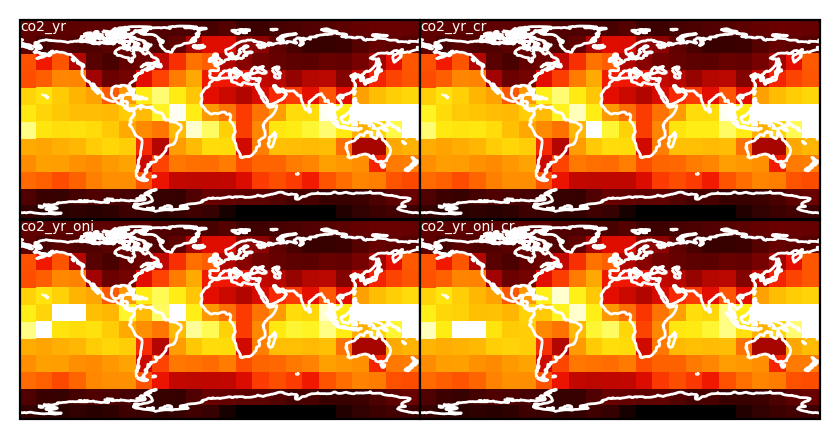

In [305]:
vmin = np.percentile(df_joint.log_Z_mean.values, 2)
vmax = np.percentile(df_joint.log_Z_mean.values, 98)
cmap = cc.cm.fire

fig = plt.figure(figsize=2*np.array([2, 1]), dpi=200)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

for i in range(2):
    for j in range(2):
        n = i + 2*j
        model = df_joint.model[n].values.item()

        ax = fig.add_subplot(gs0[i, j], projection=ccrs.PlateCarree())
        df_joint.log_Z_mean.sel(model=model).plot(ax=ax, add_colorbar=False, vmin=vmin, vmax=vmax, add_labels=False, cmap=cmap)
        ax.coastlines(color='w')
        ax.text(0, 1, model, ha='left', va='top', transform=ax.transAxes, c='w', fontsize=5)
        
(vmin, vmax)

### Find Bayesian Probability

In [306]:
df_joint['Log_BF'] = df_joint.log_Z_mean - df_joint.log_Z_mean.max(dim='model')
df_joint['Prob'] = np.exp(df_joint.Log_BF)/np.exp(df_joint.Log_BF).sum(dim='model')
df_joint

<xarray.Dataset> Size: 120kB
Dimensions:             (model: 4, lat: 12, lon: 24)
Coordinates:
  * lat                 (lat) float32 48B -83.8 -70.47 -55.24 ... 66.66 81.9
  * lon                 (lon) float32 96B 6.562 21.56 36.56 ... 336.6 351.6
  * model               (model) object 32B 'co2_yr' ... 'co2_yr_oni_cr'
Data variables: (12/13)
    log_Z_mean          (model, lat, lon) float64 9kB -5.517e+04 ... -5.031e+04
    co2_gain            (model, lat, lon) float64 9kB 2.22 2.541 ... 3.792 3.455
    offset              (model, lat, lon) float64 9kB 229.1 224.9 ... 258.7
    seasonal_amplitude  (model, lat, lon) float64 9kB 11.72 13.22 ... -11.59
    seasonal_exponent   (model, lat, lon) float64 9kB 1.259 1.257 ... 0.685
    seasonal_shift      (model, lat, lon) float64 9kB 0.7545 1.748 ... 1.804
    ...                  ...
    oni_gain            (model, lat, lon) float64 9kB 0.0 0.0 ... -0.07479
    oni_shift           (model, lat, lon) float64 9kB 0.0 0.0 0.0 ... 2.2 0.2902
    cr_gain             (model, lat, lon) float64 9kB 0.0 0.0 ... -0.0626 0.2622
    cr_shift            (model, lat, lon) float64 9kB 0.0 0.0 ... 0.9669 6.312
    Log_BF              (model, lat, lon) float64 9kB -7.071 0.0 ... -29.09
    Prob                (model, lat, lon) float64 9kB 0.0008105 ... 2.314e-13

In [ ]:
df_joint['mdl_1'] = df_joint.Prob.idxmax(dim='model')
df_joint['mdl_1_inx'] = df_joint.Prob.max(dim='model').astype(int)*0
df_joint['seasonal_amplitude_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['seasonal_exponent_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['seasonal_shift_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['offset_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['co2_gain_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['cr_gain_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['cr_shift_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['oni_gain_m'] = df_joint.Prob.max(dim='model')*0.0
df_joint['oni_shift_m'] = df_joint.Prob.max(dim='model')*0.0
for n in range(4):
    model = df_joint.model[n].values.item()
    df_joint['mdl_1_inx'] = xr.where(df_joint['mdl_1']==model, n, df_joint['mdl_1_inx'])
    df_joint['seasonal_amplitude_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['seasonal_amplitude'], df_joint['seasonal_amplitude_m'])
    df_joint['seasonal_exponent_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['seasonal_exponent'], df_joint['seasonal_exponent_m'])
    df_joint['seasonal_shift_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['seasonal_shift'], df_joint['seasonal_shift_m'])
    df_joint['offset_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['offset'], df_joint['offset_m'])
    df_joint['co2_gain_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['co2_gain'], df_joint['co2_gain_m'])
    df_joint['cr_gain_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['cr_gain'], df_joint['cr_gain_m'])
    df_joint['cr_shift_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['cr_shift'], df_joint['cr_shift_m'])
    df_joint['oni_gain_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['oni_gain'], df_joint['oni_gain_m'])
    df_joint['oni_shift_m'] = xr.where(df_joint['mdl_1']==model, df_joint.sel(model=model)['oni_shift'], df_joint['oni_shift_m'])
df_joint

<xarray.Dataset> Size: 152kB
Dimensions:               (model: 4, lat: 12, lon: 24)
Coordinates:
  * lat                   (lat) float32 48B -83.8 -70.47 -55.24 ... 66.66 81.9
  * lon                   (lon) float32 96B 6.562 21.56 36.56 ... 336.6 351.6
  * model                 (model) object 32B 'co2_yr' ... 'co2_yr_oni_cr'
Data variables: (12/27)
    log_Z_mean            (model, lat, lon) float64 9kB -5.517e+04 ... -5.031...
    co2_gain              (model, lat, lon) float64 9kB 2.22 2.541 ... 3.455
    offset                (model, lat, lon) float64 9kB 229.1 224.9 ... 258.7
    seasonal_amplitude    (model, lat, lon) float64 9kB 11.72 13.22 ... -11.59
    seasonal_exponent     (model, lat, lon) float64 9kB 1.259 1.257 ... 0.685
    seasonal_shift        (model, lat, lon) float64 9kB 0.7545 1.748 ... 1.804
    ...                    ...
    co2_gain_m            (lat, lon) float64 2kB 2.151 2.541 ... 3.54 3.963
    cr_gain_m             (lat, lon) float64 2kB 0.269 0.0 ... -0.1552 0.0
    oni_gain_m            (lat, lon) float64 2kB 0.0 0.0 0.0 ... 0.0 0.3127
    seasonal_amplitude_m  (lat, lon) float64 2kB 11.77 13.22 ... 13.43 11.71
    seasonal_exponent_m   (lat, lon) float64 2kB 1.269 1.257 ... 0.8164 0.7417
    seasonal_shift_m      (lat, lon) float64 2kB -0.2457 1.748 ... 0.3041

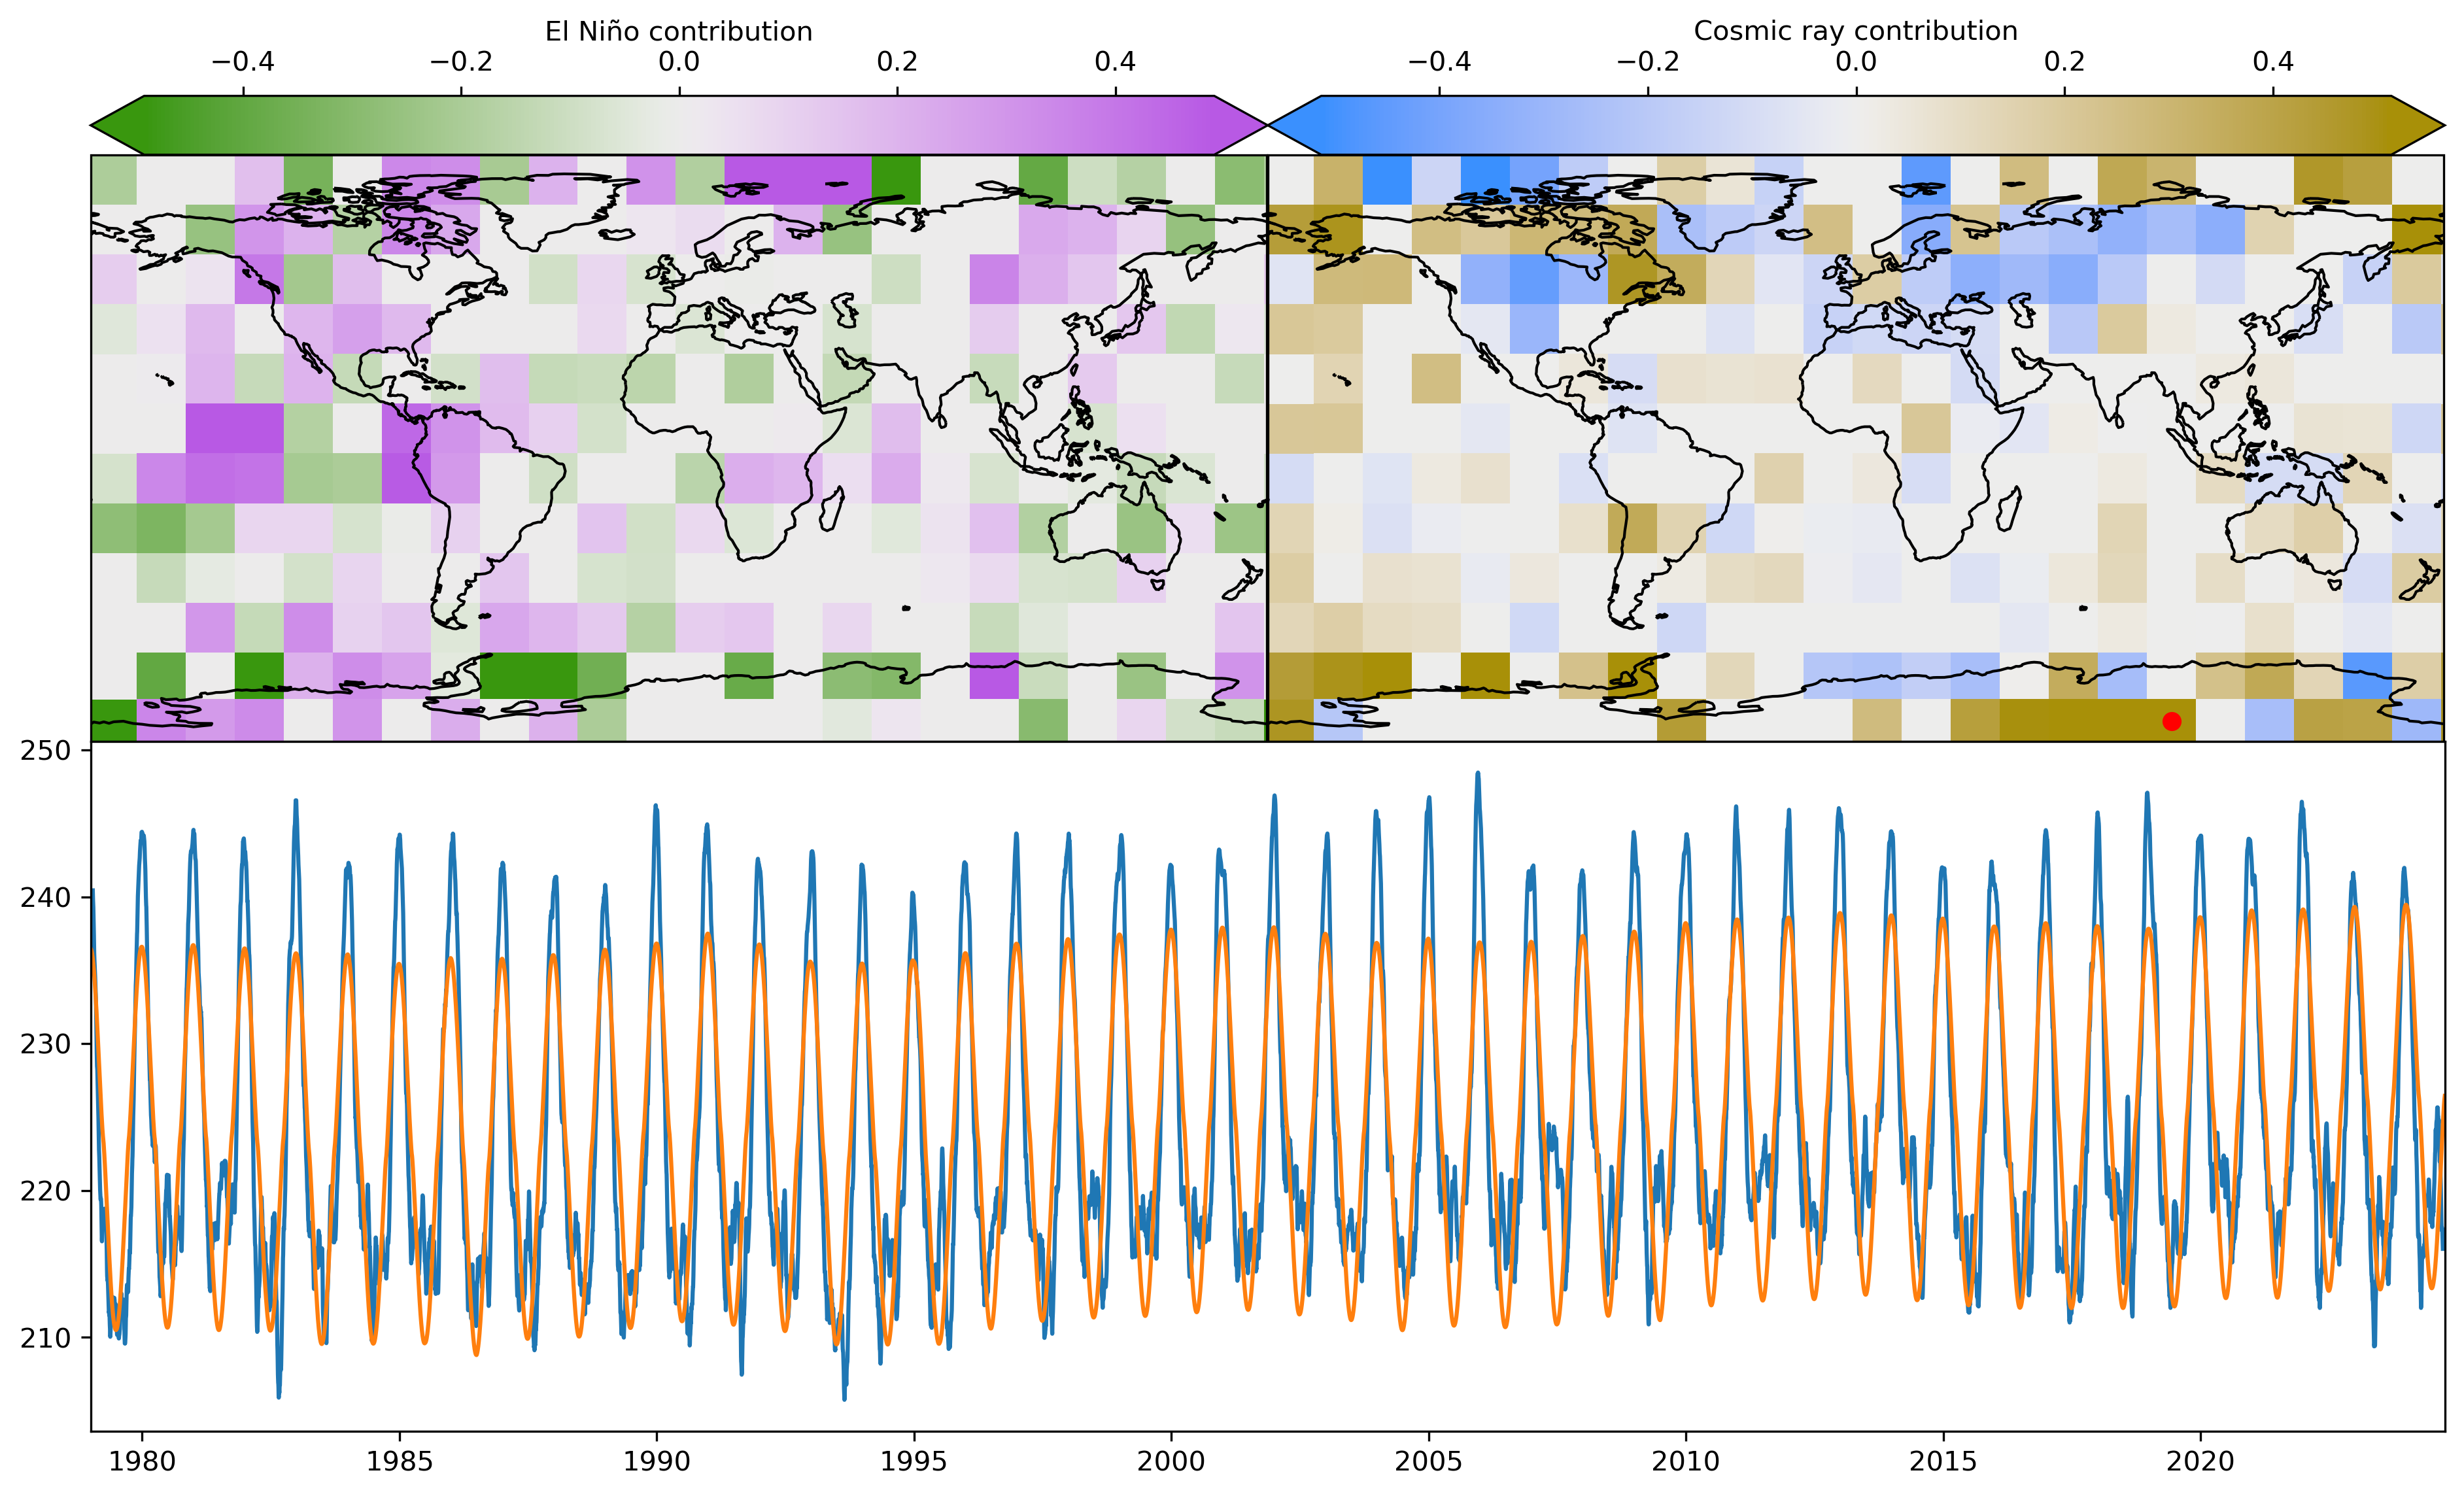

In [397]:
colors = ['#9ecae1', '#3182bd', '#fdae6b', '#e6550d']
colors = ['#9ecae1', '#9ecae1', '#e6550d', '#e6550d']
cmap = LinearSegmentedColormap.from_list('cc_cat', colors, N=4)

fig = plt.figure(figsize=6*np.array([2, 1.1725]), dpi=300)
gs0 = fig.add_gridspec(2, 2, wspace=0.0, hspace=0, left=0, right=1, bottom=0, top=1)

cbar_kwargs = {'location':'top', 'pad':0, 'anchor':(0,0), 'panchor':(0,0), 'label':None}
# cbar_kwargs['ticks'] = [0, 1, 2, 3]

# ax = fig.add_subplot(gs0[0, 0], projection=ccrs.PlateCarree())
# artist = df_joint.mdl_1_inx.plot(cmap=cmap, vmin=-0.5, vmax=3.5, cbar_kwargs=cbar_kwargs)
# ax.coastlines(color='k', lw=2)
# artist.colorbar.ax.set_xticklabels([df_joint.model[n].values.item() for n in range(4)])

# cbar_kwargs['ticks'] = [0.25, .5, .75, 1]
# cbar_kwargs['label'] = 'probability'

# cbar_kwargs.pop('ticks')
cbar_kwargs['label'] = 'Cosmic ray contribution'

contourm = np.percentile(df_joint.log_Z_mean.max(dim='model').values, 50)
contourq = np.percentile(df_joint.log_Z_mean.max(dim='model').values, 25)

vmin = np.percentile(df_joint.cr_contribution.values, 2)
vmax = np.percentile(df_joint.cr_contribution.values, 98)
vlim = np.max([np.abs(vmin), np.max(vmax)])

ax = fig.add_subplot(gs0[0, 1], projection=ccrs.PlateCarree())
df_joint.cr_gain_m.plot(cmap=cc.cm.CET_CBD1, vmin=-vlim, vmax=vlim, cbar_kwargs=cbar_kwargs)
ax.coastlines(color='k', lw=1)
# df_joint.log_Z_mean.max(dim='model').plot.contour(levels=[contourm], colors='r', linestyles='solid')
# df_joint.log_Z_mean.max(dim='model').plot.contour(levels=[contourq], colors='r', linestyles='dashed')

df_joint['cr_gain_abs'] = np.abs(df_joint.cr_gain_m)
argmax = df_joint.cr_gain_abs.argmax(dim=['lat','lon'])

lat_index = argmax['lat'].values.item()
lon_index = argmax['lon'].values.item()

lat = df_joint.lat[lat_index].values.item()
lon = df_joint.lon[lon_index].values.item()

ax.plot(lon, lat, 'ro')

cbar_kwargs['label'] = 'El Niño contribution'

vmin = np.percentile(df_joint.oni_gain_m.values, 2)
vmax = np.percentile(df_joint.oni_gain_m.values, 98)
vlim = np.max([np.abs(vmin), np.max(vmax)])

ax = fig.add_subplot(gs0[0, 0], projection=ccrs.PlateCarree())
df_joint.oni_gain_m.plot(cmap=cc.cm.CET_D2, vmin=-vlim, vmax=vlim, cbar_kwargs=cbar_kwargs)
ax.coastlines(color='k', lw=1)

# df_joint.log_Z_mean.max(dim='model').plot.contour(levels=[contourm], colors='r', linestyles='solid')
# df_joint.log_Z_mean.max(dim='model').plot.contour(levels=[contourq], colors='r', linestyles='dashed')



# Offset
offset = df_joint.offset_m.sel(lat=lat, lon=lon).values.item()

# Seasonal
seasonal_shift = df_joint.seasonal_shift_m.sel(lat=lat, lon=lon).values.item()
seasonal_amplitude = df_joint.seasonal_amplitude_m.sel(lat=lat, lon=lon).values.item()
seasonal_exponent = df_joint.seasonal_exponent_m.sel(lat=lat, lon=lon).values.item()

# ONI
oni = oni_data
orbits_oni = ((oni.time-np.min(geo_data_coarse.time))/np.timedelta64(1, 'D')/365.256).values
oni_gain = df_joint.oni_gain_m.sel(lat=lat, lon=lon).values.item()
oni_shift = df_joint.oni_shift_m.sel(lat=lat, lon=lon).values.item()

# CR
orbits_cr = ((cr.time-np.min(geo_data_coarse.time))/np.timedelta64(1, 'D')/365.256).values
cr_gain = df_joint.cr_gain_m.sel(lat=lat, lon=lon).values.item()
cr_shift = df_joint.cr_shift_m.sel(lat=lat, lon=lon).values.item()


# CO2
co2_gain = df_joint.co2_gain_m.sel(lat=lat, lon=lon).values.item()

sin_orbits = np.sin((orbits - seasonal_shift)*2*np.pi)
estimate = (seasonal_amplitude*jnp.sign(sin_orbits)*jnp.pow(jnp.abs(sin_orbits), seasonal_exponent)
                            + orbits/jnp.max(orbits)*co2_gain  + offset
                            + oni_gain*jnp.interp(orbits-jnp.abs(oni_shift), orbits_oni, oni.normalized.values)
                            + cr_gain*jnp.interp(orbits-jnp.abs(cr_shift), orbits_cr, cr.normalized.values))

ax = fig.add_subplot(gs0[1, 0:2])

ax.plot(geo_data.time, geo_data_coarse.air.sel(lat=lat,lon=lon,level=2).rolling(time=30, center=True).mean())
ax.plot(geo_data.time, estimate)
ax.set_xlim([np.min(geo_data.time), np.max(geo_data.time)])

# ax = fig.add_subplot(gs0[1, 0], projection=ccrs.PlateCarree())
# df_joint.oni_shift_m.plot(cmap=cc.cm.coolwarm, vmin=-5, vmax=5, cbar_kwargs=cbar_kwargs)
# ax.coastlines(color='k', lw=1)

# ax = fig.add_subplot(gs0[1, 1], projection=ccrs.PlateCarree())
# df_joint.cr_shift_m.plot(cmap=cc.cm.coolwarm, vmin=-5, vmax=5, cbar_kwargs=cbar_kwargs)
# ax.coastlines(color='k', lw=1)



fig.savefig(f'{DATA_LABEL}_{coarsen_level}.png', bbox_inches='tight')




In [393]:
np.mean((geo_data_coarse.air.sel(lat=lat,lon=lon,level=2).rolling(time=20, center=True).mean()-estimate)**2).values

array(28.61800335)

In [391]:
np.mean((geo_data_coarse.air.sel(lat=lat,lon=lon,level=2).rolling(time=20, center=True).mean()-estimate)**2).values

array(27.75487525)

In [396]:
geo_data.time

<xarray.DataArray 'time' (time: 16710)> Size: 134kB
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2024-09-28T00:00:00.000000000',
       '2024-09-29T00:00:00.000000000', '2024-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 134kB 1979-01-01 1979-01-02 ... 2024-09-30
Attributes:
    long_name:           Time
    delta_t:             0000-00-01 00:00:00
    standard_name:       time
    axis:                T
    avg_period:          0000-00-01 00:00:00
    bounds:              time_bnds
    actual_range:        [1621680. 1630416.]
    coordinate_defines:  start

In [376]:
geo_data_coarse.level.values

array([2.], dtype=float32)

In [310]:
df_joint.cr_shift_m.values.shape

(12, 24)